In [236]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

In [237]:
def model_validation(df, results, forecast_length=365):
    df["forecast"] = results.predict(start=df.index[-forecast_length], end=df.index[-1], dynamic=False)
    
    forecast_test_data_plot = plt.figure(figsize=(12, 6))
    ax = forecast_test_data_plot.add_subplot(111)
    ax.set_title('Forecast of Temperature')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Temperature (C)')
    ax.plot(df.index[-forecast_length * 5:-forecast_length], df["mean"][-forecast_length * 5:-forecast_length], label="Observed")
    ax.plot(df.index, df["Forecast"], label="Forecast")
    ax.legend()
    plt.show()

In [238]:
train_data = pd.read_csv('Data/train_data.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)
train_data = train_data.resample('D').asfreq().fillna(method='ffill')
train_data = train_data[train_data.index >= '2020-01-01']

In [239]:
#Creating Differences for ADF test

train_data["Temp. First Difference"] = train_data["mean"] - train_data["mean"].shift(1)
train_data["Seasonal Difference"] = train_data["mean"] - train_data["mean"].shift(365)
train_data["Seasonal First Difference"] = train_data["Temp. First Difference"] - train_data[
    "Temp. First Difference"
].shift(365)

In [240]:
def adf_check(series):
    
        results = adfuller(series, autolag='AIC')
        print()
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("Augmented Dickey-Fuller Unit Root Test:")
        labels = [
            "ADF Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ]
        
        for value, label in zip(results, labels):
            print(f"{label} : {value}")
            
        if results[1] <= 0.05:
            print("Reject the null hypothesis: Series is stationary and has no unit root")
        else:
            print("Weak evidence against the null hypothesis: Series is non-stationary and has a unit root")
            
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        

adf_check(train_data['mean'])

adf_check(train_data["Seasonal Difference"].dropna())


adf_check(train_data["Seasonal First Difference"].dropna())
    


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -2.5649592440761833
p-value : 0.10045787733368433
#Lags Used : 12
Number of Observations Used : 1539
Weak evidence against the null hypothesis: Series is non-stationary and has a unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -4.7109385474695245
p-value : 8.026002763691947e-05
#Lags Used : 23
Number of Observations Used : 1163
Reject the null hypothesis: Series is stationary and has no unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -10.209796355837195
p-value : 5.677734758606674e-18
#Lags Used : 23
Number of Observations Used : 1162
Reject the null hypothesis: Series is stationary and has no unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


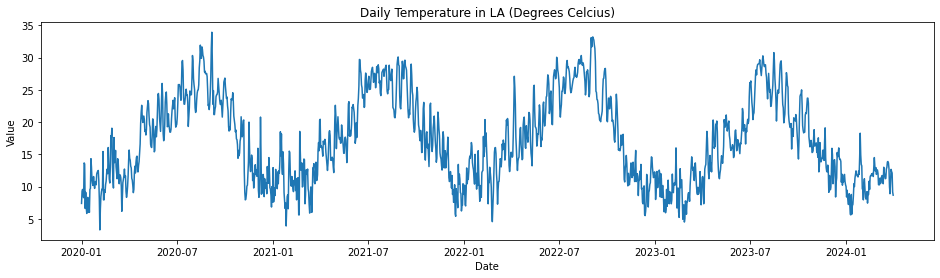

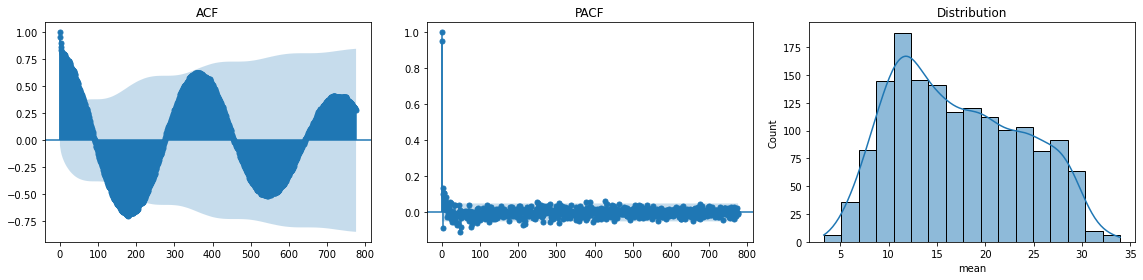

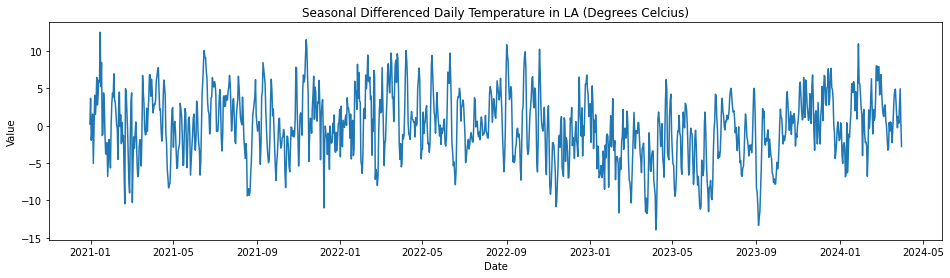

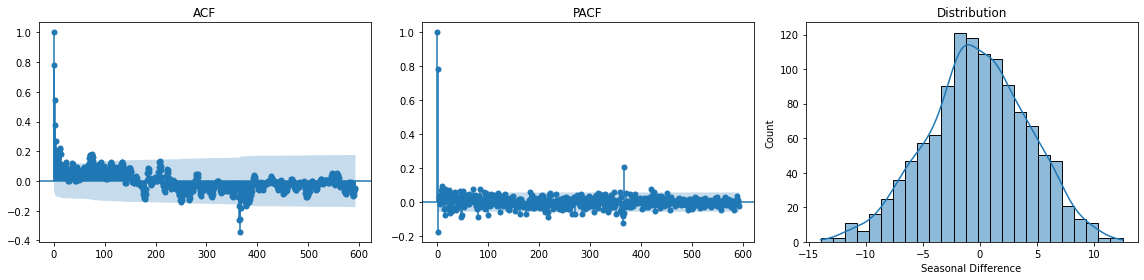

In [241]:
def plot_data_properties(data, ts_plot_name="Time Series plot"):
    data = data.dropna()

    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Value')
    plt.xlabel('Date')

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    plot_acf(data, ax=axes[0], lags=min(4000, len(data)//2 - 1))
    axes[0].set_title("ACF")

    plot_pacf(data, ax=axes[1], lags=min(4000, len(data)//2 - 1), method='ywm')
    axes[1].set_title("PACF")

    sns.histplot(data, ax=axes[2], kde=True)
    axes[2].set_title("Distribution")

    plt.tight_layout()
    plt.show()

    
    
plot_data_properties(train_data['mean'], 'Daily Temperature in LA (Degrees Celcius)')

plot_data_properties(train_data['Seasonal Difference'], 'Seasonal Differenced Daily Temperature in LA (Degrees Celcius)')


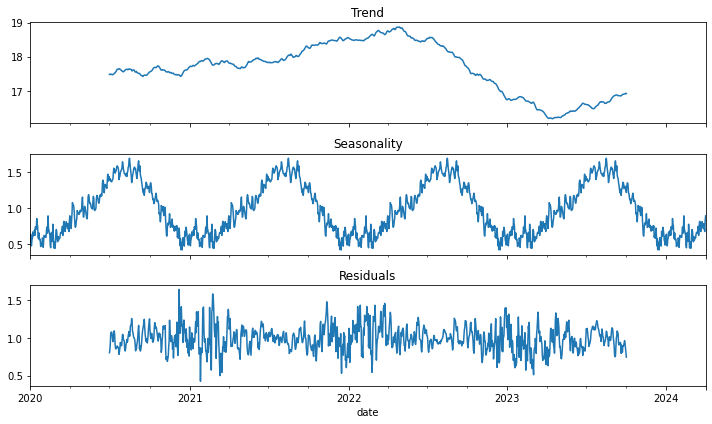

In [242]:
def plot_seasonal_decompose(data, model, period):
    '''
    Plots trend, seasonality and residuals.
    
    Parameters:
    ----------
    data (pd.Series): Time series data
    model (str): 'additive' or 'multiplicative'
    period (int): Number of observations per cycle (e.g., 365 for daily data with yearly seasonality)
    
    Returns:
    -------
    decomposition (obj): Decomposition result
    '''
    decomposition = seasonal_decompose(data, model=model, period=period)
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    decomposition.trend.plot(ax=axes[0], title='Trend')
    decomposition.seasonal.plot(ax=axes[1], title='Seasonality')
    decomposition.resid.plot(ax=axes[2], title='Residuals')
    
    plt.tight_layout()
    plt.show()
    
    return decomposition

decomposition = plot_seasonal_decompose(train_data['mean'], 'multiplicative', period=365)


In [243]:
model = SARIMAX(
    train_data["mean"],
    order=(3, 0, 0),
    seasonal_order=(0, 1, 0, 365), 
    trend='c')

results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                mean   No. Observations:                 1552
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 365)   Log Likelihood               -2861.942
Date:                             Wed, 23 Apr 2025   AIC                           5733.883
Time:                                     11:47:56   BIC                           5759.279
Sample:                                 01-01-2020   HQIC                          5743.455
                                      - 03-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0445      0.079     -0.565      0.572      -0.199       0.110
ar.L1          0.9269      

In [244]:
resid = results.resid

# turn to a df
resid = pd.DataFrame(resid)

# Remove the first 365 rows
resid = resid.iloc[365:]

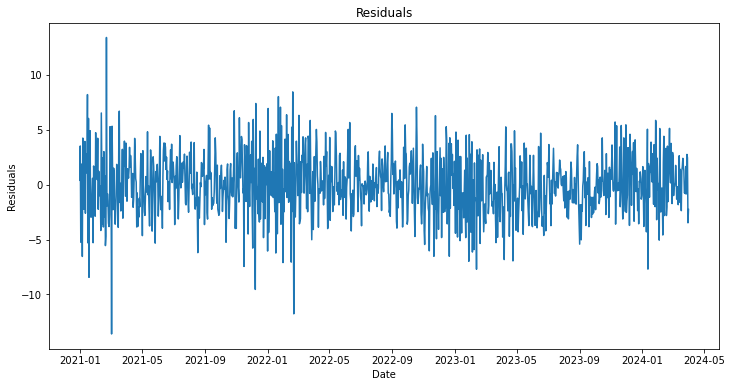

<AxesSubplot:title={'center':'Residuals Kernel Denisity Function'}, xlabel='Date', ylabel='Density'>

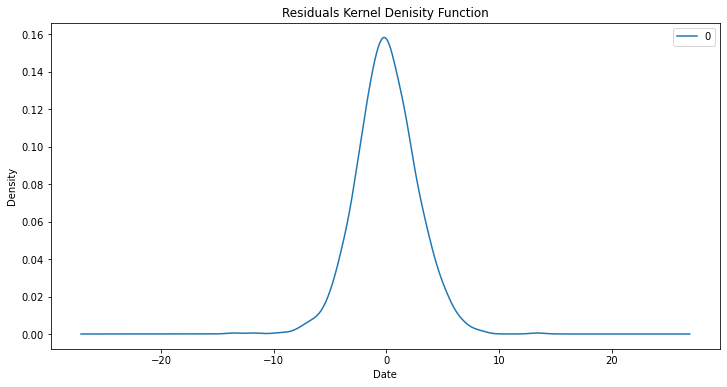

In [245]:
resid_plots1 = plt.figure(figsize=(12, 6))
plt.plot(resid)
plt.title("Residuals", figure=resid_plots1)
plt.xlabel("Date", figure=resid_plots1)
plt.ylabel("Residuals", figure=resid_plots1)
plt.show()

resid_plots2 = plt.figure(figsize=(12, 6))
ax = resid_plots2.add_subplot(111)
plt.title("Residuals Kernel Denisity Function", figure=resid_plots2)
plt.xlabel("Date", figure=resid_plots2)
resid.plot(kind='kde', ax=ax)

<AxesSubplot:title={'center':'Rolling Variance of Residuals'}, xlabel='date'>

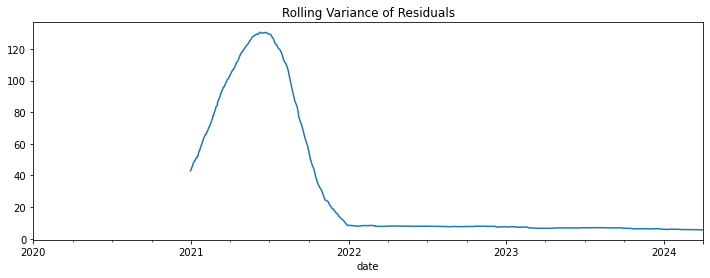

In [246]:
residuals = results.resid
rolling_var = residuals.rolling(window=365).var()
rolling_var.plot(figsize=(12,4), title='Rolling Variance of Residuals')

In [247]:
from scipy.stats import shapiro
def shapiro_normality_test(data):
    p_value = shapiro(data)[1]
    if p_value >= 0.05:
        print("Data follows normal distribution: X~N"+ str((np.round(np.mean(data),3), np.round(np.std(data),3))))
        print("Shapiro test p_value={}".format(np.round(p_value,3)))
    else:
        print("Data failed shapiro normality test with p_value={}".format(p_value))

shapiro_normality_test(resid)
        

Data failed shapiro normality test with p_value=3.029921344932518e-06


In [248]:
test_data = pd.read_csv('Data/test_data.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)
test_data = test_data.resample('D').asfreq().fillna(method='ffill')

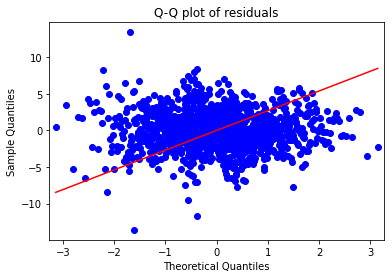

In [249]:
# make a Q-Q plot of the residuals
from scipy.stats import zscore
sm.qqplot(resid, line='s')
plt.title("Q-Q plot of residuals")
plt.show()



In [250]:
forecast_length = 31

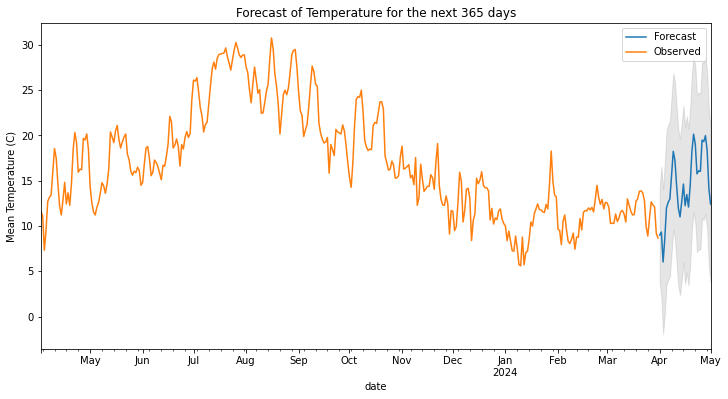

In [251]:
future_dates = pd.date_range(start=train_data.index[-1] + dt.timedelta(days=1), periods=forecast_length, freq='D')
future_df = pd.DataFrame(index=future_dates, columns=train_data.columns)

future_df["forecast"] = results.predict(start=future_dates[0], end=future_dates[-1], dynamic= False)
plot_length = 365

forecast_test_data_plot = plt.figure(figsize=(12, 6))
ax = forecast_test_data_plot.add_subplot(111)
plt.title(f'Forecast of Temperature for the next {365} days', figure=forecast_test_data_plot)
plt.xlabel('Date', figure=forecast_test_data_plot)
plt.ylabel('Mean Temperature (C)', figure=forecast_test_data_plot)
future_df["forecast"].plot(ax=ax, label='Forecast')
train_data['mean'][-plot_length:].plot(ax=ax, label='Observed')
plt.fill_between(future_df.index, 
                 results.get_forecast(steps=forecast_length).conf_int()['lower mean'], 
                 results.get_forecast(steps=forecast_length).conf_int()['upper mean'], 
                 color='gray', alpha=0.2)
plt.legend()
plt.show()
plt.show()


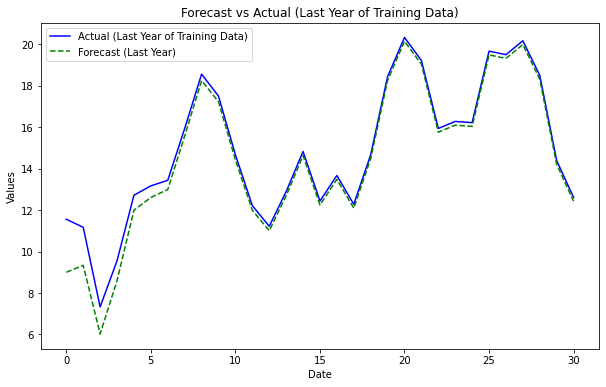

In [252]:
# Extract the last year of the training data
last_year = train_data['mean'][-365:- 365 + forecast_length]  # Adjust the slicing based on your data's frequency (e.g., daily, monthly)
last_year.reset_index(drop=True, inplace=True)
# Generate the forecast for the same period as the last year of training data
test = future_df["forecast"].reset_index(drop=True)

# Plot the actual data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(last_year.index, last_year, label="Actual (Last Year of Training Data)", color="blue")
plt.plot(last_year.index, test, label="Forecast (Last Year)", color="green", linestyle="--")
plt.title("Forecast vs Actual (Last Year of Training Data)")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

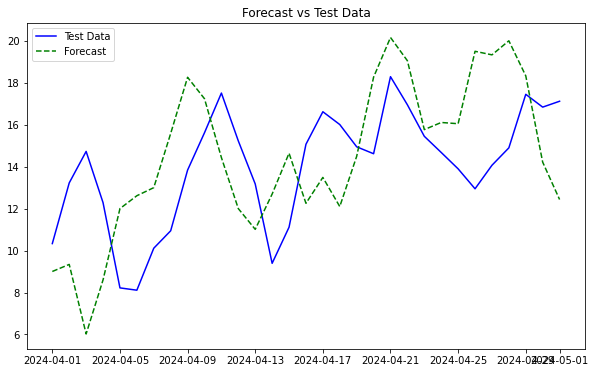

In [253]:
# Plot the forecast against the test data
plt.figure(figsize=(10, 6))
plt.plot(test_data['mean'][:forecast_length], label="Test Data", color="blue")

# Align the index of the test Series with test_data
test.index = test_data[:forecast_length].index

plt.plot(test, label="Forecast", color="green", linestyle="--")
plt.title("Forecast vs Test Data")
plt.legend()
plt.show()


In [254]:
#Calculate the RMSE and MAE and MASE
def calculate_errors(test, forecast):
    rmse = np.sqrt(np.mean((test - forecast) ** 2))
    mae = np.mean(np.abs(test - forecast))
    mase = mae / np.mean(np.abs(np.diff(test)))
    
    return rmse, mae, mase
rmse, mae, mase = calculate_errors(test_data['mean'][:31], test)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MASE: {mase}")

RMSE: 3.713365118910609
MAE: 3.277346121696598
MASE: 1.88642332407709


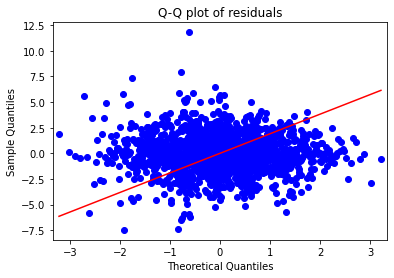

In [261]:
# make a Q-Q plot of the residuals
sm.qqplot(resid, line='s')
plt.title("Q-Q plot of residuals")
plt.show()

In [262]:
forecast_length = 31

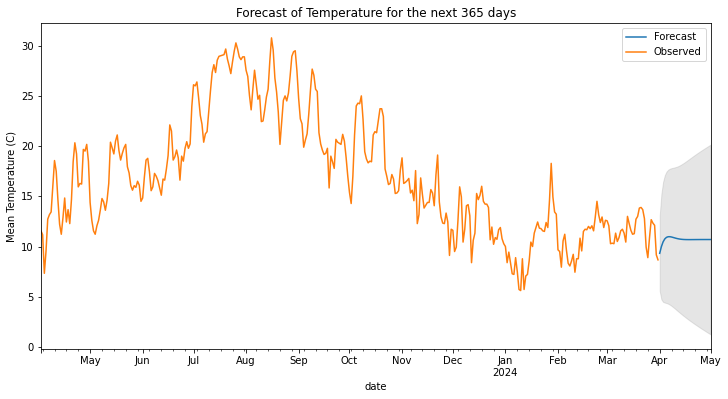

In [263]:
future_dates = pd.date_range(start=train_data.index[-1] + dt.timedelta(days=1), periods=forecast_length, freq='D')
future_df = pd.DataFrame(index=future_dates, columns=train_data.columns)

future_df["forecast"] = models[-1].predict(start=future_dates[0], end=future_dates[-1], dynamic= True)
plot_length = 365

forecast_test_data_plot = plt.figure(figsize=(12, 6))
ax = forecast_test_data_plot.add_subplot(111)
plt.title(f'Forecast of Temperature for the next {365} days', figure=forecast_test_data_plot)
plt.xlabel('Date', figure=forecast_test_data_plot)
plt.ylabel('Mean Temperature (C)', figure=forecast_test_data_plot)
future_df["forecast"].plot(ax=ax, label='Forecast')
train_data['mean'][-plot_length:].plot(ax=ax, label='Observed')
plt.fill_between(future_df.index, 
                 models[-1].get_forecast(steps=forecast_length).conf_int()['lower mean'], 
                 models[-1].get_forecast(steps=forecast_length).conf_int()['upper mean'], 
                 color='gray', alpha=0.2)
plt.legend()
plt.show()
plt.show()


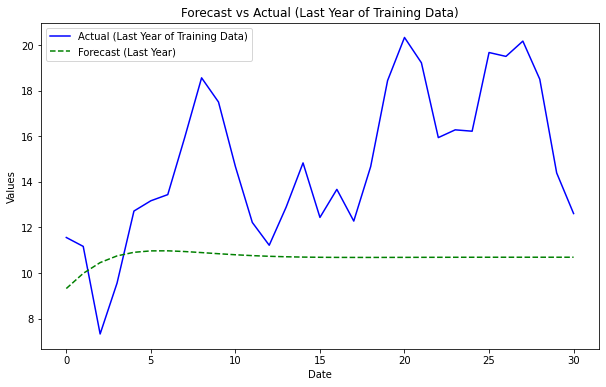

In [264]:
# Extract the last year of the training data
last_year = train_data['mean'][-365:- 365 + forecast_length]  # Adjust the slicing based on your data's frequency (e.g., daily, monthly)
last_year.reset_index(drop=True, inplace=True)
# Generate the forecast for the same period as the last year of training data
test = future_df["forecast"].reset_index(drop=True)

# Plot the actual data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(last_year.index, last_year, label="Actual (Last Year of Training Data)", color="blue")
plt.plot(last_year.index, test, label="Forecast (Last Year)", color="green", linestyle="--")
plt.title("Forecast vs Actual (Last Year of Training Data)")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

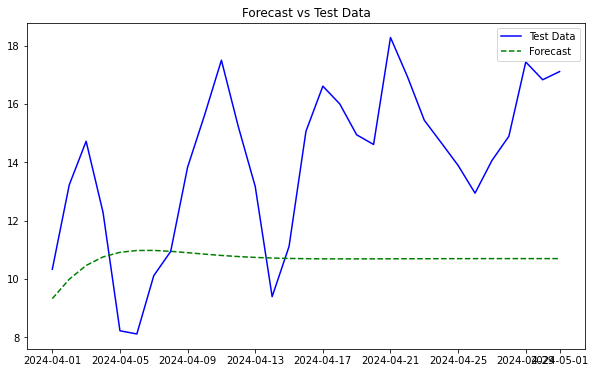

In [265]:
# Plot the forecast against the test data
plt.figure(figsize=(10, 6))
plt.plot(test_data['mean'][:forecast_length], label="Test Data", color="blue")

# Align the index of the test Series with test_data
test.index = test_data[:forecast_length].index

plt.plot(test, label="Forecast", color="green", linestyle="--")
plt.title("Forecast vs Test Data")
plt.legend()
plt.show()


In [266]:
#Calculate the RMSE and MAE and MASE
def calculate_errors(test, forecast):
    rmse = np.sqrt(np.mean((test - forecast) ** 2))
    mae = np.mean(np.abs(test - forecast))
    mase = mae / np.mean(np.abs(np.diff(test)))
    
    return rmse, mae, mase
rmse, mae, mase = calculate_errors(test_data['mean'][:31], test)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MASE: {mase}")

RMSE: 4.293003734669507
MAE: 3.8099453966802974
MASE: 2.1929846872680145


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

def best_arima_model(train_data, p, q, d=[1]):
    best_model_aic = np.inf
    best_model_bic = np.inf
    best_model_hqic = np.inf
    best_model_order = None
    current_best_model = None
    models = []

    for p_ in p:
        for q_ in q:
            for d_ in d:
                try:
                    model = ARIMA(train_data, order=(p_, d_, q_)).fit()
                    models.append(model)

                    no_of_lower_metrics = sum([
                        model.aic <= best_model_aic,
                        model.bic <= best_model_bic,
                        model.hqic <= best_model_hqic
                    ])

                    if no_of_lower_metrics >= 2:
                        best_model_aic = model.aic
                        best_model_bic = model.bic
                        best_model_hqic = model.hqic
                        best_model_order = (p_, d_, q_)
                        current_best_model = model

                        print(f"Best model so far: ARIMA{best_model_order} "
                              f"AIC:{best_model_aic:.0f} BIC:{best_model_bic:.0f} HQIC:{best_model_hqic:.0f} "
                              f"resid mean: {np.round(model.resid.mean(), 3)}")

                except Exception as e:
                    print(f"Failed for ARIMA({p_},{d_},{q_}): {e}")
                    continue

    if current_best_model is not None:
        print('\nBest Model Summary:\n')
        print(current_best_model.summary())
        return current_best_model, models
    else:
        print("No model converged.")
        return None, models


best, models = best_arima_model(train_data['mean'], p=[0, 1, 2, 3], q=[0, 1, 2, 3], d=[0,1])

In [ ]:
resid = models[-1].resid

resid = pd.DataFrame(resid)
resid = resid.iloc[1:]

In [ ]:
resid_plots1 = plt.figure(figsize=(12, 6))
plt.plot(resid)
plt.title("Residuals", figure=resid_plots1)
plt.xlabel("Date", figure=resid_plots1)
plt.ylabel("Residuals", figure=resid_plots1)
plt.show()

resid_plots2 = plt.figure(figsize=(12, 6))
ax = resid_plots2.add_subplot(111)
plt.title("Residuals Kernel Denisity Function", figure=resid_plots2)
plt.xlabel("Date", figure=resid_plots2)
resid.plot(kind='kde', ax=ax)

In [ ]:
residuals = results.resid
rolling_var = residuals.rolling(window=365).var()
rolling_var.plot(figsize=(12,4), title='Rolling Variance of Residuals')

In [ ]:
from scipy.stats import shapiro
def shapiro_normality_test(data):
    p_value = shapiro(data)[1]
    if p_value >= 0.05:
        print("Data follows normal distribution: X~N"+ str((np.round(np.mean(data),3), np.round(np.std(data),3))))
        print("Shapiro test p_value={}".format(np.round(p_value,3)))
    else:
        print("Data failed shapiro normality test with p_value={}".format(p_value))

shapiro_normality_test(resid)
        

In [ ]:
test_data = pd.read_csv('Data/test_data.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)
test_data = test_data.resample('D').asfreq().fillna(method='ffill')

In [ ]:
# make a Q-Q plot of the residuals
sm.qqplot(resid, line='s')
plt.title("Q-Q plot of residuals")
plt.show()


In [ ]:
forecast_length = 31

In [ ]:
future_dates = pd.date_range(start=train_data.index[-1] + dt.timedelta(days=1), periods=forecast_length, freq='D')
future_df = pd.DataFrame(index=future_dates, columns=train_data.columns)

future_df["forecast"] = models[-1].predict(start=future_dates[0], end=future_dates[-1], dynamic= True)
plot_length = 365

forecast_test_data_plot = plt.figure(figsize=(12, 6))
ax = forecast_test_data_plot.add_subplot(111)
plt.title(f'Forecast of Temperature for the next {365} days', figure=forecast_test_data_plot)
plt.xlabel('Date', figure=forecast_test_data_plot)
plt.ylabel('Mean Temperature (C)', figure=forecast_test_data_plot)
future_df["forecast"].plot(ax=ax, label='Forecast')
train_data['mean'][-plot_length:].plot(ax=ax, label='Observed')
plt.fill_between(future_df.index, 
                 models[-1].get_forecast(steps=forecast_length).conf_int()['lower mean'], 
                 models[-1].get_forecast(steps=forecast_length).conf_int()['upper mean'], 
                 color='gray', alpha=0.2)
plt.legend()
plt.show()
plt.show()


In [ ]:
# Plot the forecast against the test data
plt.figure(figsize=(10, 6))
plt.plot(test_data['mean'][:forecast_length], label="Test Data", color="blue")

# Align the index of the test Series with test_data
test.index = test_data[:forecast_length].index

plt.plot(test, label="Forecast", color="green", linestyle="--")
plt.title("Forecast vs Test Data")
plt.legend()
plt.show()


In [ ]:
#Calculate the RMSE and MAE and MASE
def calculate_errors(test, forecast):
    rmse = np.sqrt(np.mean((test - forecast) ** 2))
    mae = np.mean(np.abs(test - forecast))
    mase = mae / np.mean(np.abs(np.diff(test)))
    
    return rmse, mae, mase
rmse, mae, mase = calculate_errors(test_data['mean'][:31], test)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MASE: {mase}")